# `DeepGalerkin`-model: solving PDEs with NNs

Welcome! In this tutorial you'll learn how to solve partial differential equations (PDEs) with neural networks using `DeepGalerkin`-model from `BatchFlow`, inspired by the paper [DGM: A deep learning algorithm for solving partial differential equations](http://arxiv.org/abs/1708.07469). The notebook
* starts with general setup of the PDE solved by `DeepGalerkin`
* then explains in detail how the model is configured
* finally, demonstrates how to use the model for solving common pde-problems, including *[heat-equation](https://en.wikipedia.org/wiki/Heat_equation)* and *[wave-equation](https://en.wikipedia.org/wiki/Wave_equation)*.

To get full understanding of `DeepGalerkin`, we suggest you to read this tutorial starting from the problem setup. The alternative is to jump straight to the working examples:
* [first-order ode $\mathcal{R}$](#ex1)
* [poisson equation in $\mathcal{R}^2$](#ex2)
* [heat equation in $\mathcal{R}^2 \times \mathcal{R}$](#ex3)
* [wave equation in $\mathcal{R}$](#ex4)
* [equation with non-constant coefficients in $\mathcal{R}$](#ex5)
* [system of two equations in $\mathcal{R}$](#ex6)

**Note**: `DeepGalerkin` is written in [TensorFlow](https://www.tensorflow.org/). Throughout the notebook `tf` will stand for `TensoFlow`.

## Setup of the PDE-problem

With `DeepGalerkin`-model one can solve almost any conceivable PDE. Still, the model is most suited for solving evolution-equations with time of up to the second order with boundary and initial conditions. In general form, the PDE-problem for the model looks as follows:
<a id='eq'></a>
$$
F\left(u; t, x_1,\dots, x_{n-1};
\frac{\partial u}{\partial t},\frac{\partial^2 u}{\partial t^2};
\dots, \frac{\partial u}{\partial x_i}, \dots
\frac{\partial^2 u}{\partial x_i x_j}, \dots
\frac{\partial^3 u}{\partial x_i x_j x_k},\dots
\right) = 0.
$$
The problem is solved on rectangular domain
<a id='dom'></a>
$$
\Omega = [g_0^1, g_1^1] \times \dots \times [g_0^n, g_1^n] ,\quad u: \mathcal{R}^n \rightarrow \mathcal{R}
$$
While initial conditions fix the initial state and evolution rate of the system:
<a id='inc_0'></a>
$$
u(x_1, \dots, x_{n-1}, g_0^n) = u_0(x_1, \dots, x_{n-1}),
$$
<a id='inc_1'></a>
$$
\frac{\partial u(x_1, \dots, x_{n-1}, g_0^n)}{\partial t} = u_0'(x_1, \dots, x_{n-1}).
$$
When only first-order time derivative is presented in form $F$, only the initial value of system is needed:
$$
u(x_1, \dots, x_{n-1}, g_0^n) = u_0(x_1, \dots, x_{n-1}).
$$
`DeepGalerkin` also uses `Dirichlet`-boundary conditions:
<a id='inc_3'></a>
$$
u(\sigma \Omega) = u_{\sigma} = c(x).
$$
**Note**: $F$, $u_0$, $u_0'$ and $c$ are closed-form expressions composed from operations `+`, `-`, `*`, `\`, differential operator $D(\cdot, x)$, tokens `sin`, `cos`, `exp` and [many more]().

## Math behind `DeepGalerkin`

The main idea of `DeepGalerkin` is to substitute network $net(x; \theta)$ into the form $F$ and fit $\theta$ of  so that the difference between left-hand-side (lhs) of the PDE and right-hand-size (rhs) be small:
<a id='dist'></a>
$$
e(x) = F\left(net(x; \theta); t, x_1,\dots, x_{n-1}; \frac{\partial net(x; \theta)}{\partial t},\frac{\partial^2 net(x; \theta)}{\partial t^2},\dots\right),
$$
$$
Loss(\theta) = \int\limits_{\Omega} L\left[e(x)\right] \mathcal{P}( d x),
$$
$$
Loss(\theta) \rightarrow \min\limits_{\theta}.
$$
**Note:** In practice, $Loss(\theta)$ is estimated on a sample(batch) of points $\{(x^i_1,\dots, x^i_n)\}_{i=1,\dots,N}$.
As the distribution $\mathcal{P}$ is not fixed, any sampling scheme can be used.

## Configuring `DeepGalerkin`

Configuring `DeepGalerkin` comes down to
* specification of the equation solved by the model in `pde`-dict
* setting other parameters of the model inherited from base-class [`batchflow.models.TfModel`](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.base.html), e.g. network-architecture and loss-function
* configuring how to form batches of training data and feed them into the training loop
* [optional] specifying gradients for tracking (for instance, for debugging purposes)

### 1.PDE setup in `pde`-dict

It consists of several steps:
* defining the dimensionality of the problem:
```
'n_dims': number_of_variables
```
* describing differential form in lhs of the [equation](#eq) as a function of `u`, `x`, `y`, `t`,$\dots$. This corresponds to the key `form`:
```
'form': callable_form
```
Notably, `callable_form` is written using special token `D(u, t)` for differential operator and [other tokens](tokens) (think `sin`, `exp`, `-`) for unary and binary operations, e.g
```
'form': lambda u, x, t: D(D(u, x), x) - sin(x) * D(u, t)
```
stands for equation
$$
\frac{\partial^2{u}}{\partial{t^2}} - \sin{x}\frac{\partial{u}}{\partial{t}} = 0.
$$

* defining the [domain](#dom) of the problem:
```
'domain' : [[g_0^1, g_1^1],...,[g_0^n, g_1^n]]
```
**Note**: if the key is not specified, the domain is set to `[[0, 1],...,[0, 1]]`
* setting initial/boundary conditions. In case of PDEs with time-variable, e.g. heat-equation, one needs to fix initial value of the system ($u(x_1, \dots, x_n, t=0)$) using `initial_condition`:
```
'initial_condition': constant or callable
```
where `callable` is also composed from [predefined tokens](). Importantly, when $\frac{\partial^2{u}}{\partial{t^2}}$ is presented in lhs of the equation (e.g. [wave equation](#eq)), one needs to fix **both** initial value and initial rate of the system ($\frac{\partial{u}}{\partial{t}}(x_1, \dots, x_n, t=0)$):
```
'initial_condition': (callable_1, callable_2)
```
When `initial_condition` is not present in configuration-dict, `boundary-condition` [$u_{\sigma}$](#inc_3) must be supplied (default value is 0):
```
'boundary_condition': constant or callable
```
* [optional] choosing the mode of `time_multiplier`: a multiplier, used for binding initial conditions. Can be either `sigmoid` or `polynomial` or callable. Go [here](https://github.com/analysiscenter/batchflow/blob/deep_galerkin/batchflow/models/tf/deep_galerkin.py#L150) for more info.

### 2. Setting other parameters of `DeepGalerkin`

The easiest way to choose the architecture of network $net(x; \theta)$ is to use [batchflow's convolution block](https://analysiscenter.github.io/batchflow/intro/tf_layers.html) in [network's body](https://analysiscenter.github.io/batchflow/intro/tf_models.html). For instance, this combination of keys
```
'body':{'layout' : 'fa fa f',
        'units' : [10, 15, 1],
        'activation' : [tf.nn.tanh, tf.nn.tanh]}
```
corresponds to a `f`ully-connected network with two hidden layers (of 10 and 15 units), one output-unit and two `tanh`-`a`ctivations. The specification of `loss` and other parameters is straightforward:
```
'loss':'mse'
```

### 3. Setting up the data-feeding procedure
It consists of two steps

* choosing the sampling scheme from $\Omega$ (fixing the distribution $\mathcal{P}$).
The most convenient way is to use [`Sampler`-class](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/07_sampler.ipynb). For instance, this line
```
s = (0.5 + NumpySampler('normal', dim=2)).truncate((1, 1), (0, 0)) 
```
creates an object, that can sample points from a 2-dimensional Gaussian with center at $(0.5, 0.5)$ truncated into the box $[0, 1] \times [0, 1]$:
```
sample_of_size_10 = s.sample(size=10)
```
* feeding sampled batches into the network-training loop. The easiest way is to wrap a callable, that samples points (`s.sample` in our example), into a [batchflow's named expression L](https://analysiscenter.github.io/batchflow/intro/named_expr.html):
```
train = (Pipeline()
          .init_model(name='galerkin', ...)
          .train_model('galerkin',
                       feed_dict={'points': L(s.sample, size=F(len))} # wrap sampler
                       ))
```

### 4. Tracking gradients of $net(x, \theta)$ w.r.t its input $x$.

Sometimes the network does not seem to train at all. In this case, it may be useful to take a look at terms forming the [loss](#dist): first/second order derivatives of network-output with respect to its input-coordinates:

$$
\frac{\partial net(x; \theta)}{\partial x_i},\ \frac{\partial^2 net(x; \theta)}{\partial x_i^2},\
\frac{\partial^2 net(x; \theta)}{\partial x_i \partial x_j}
$$

It is as simple as adding the following key to the model-config:

```
'track': {'dx': lambda u, x, t: D(u, x) ,            # first-order derivative w.r.t. first coordinate
          'd2xy': lambda u, x, y, t: D(D(u, x), y),  # second-order mixed derivative
          'dt': lambda u, x, y, t: D(u, t)}          # derivative w.r.t. to last coordinate
                                                     # make sure to incorporate all variables in lambda
                                                     # even when they are not used
```

## Examples: Solving common PDEs with `DeepGalerkin`

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import sys

warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
from deepde import DeepSolver, NumpySampler, cart_prod

<a id='tokens'></a>

As was mentioned earlier, we have custom language to define PDE's. To use it, execute following code:

In [3]:
from deepde import add_tokens
add_tokens()

It automatically adds names like `sin`, `cos`, `exp` to current namespace, allowing to use it without cluttering your code with things like `tf.sin`, `torch.cos`, `np.exp`.

**Note**: by default, all of the functions are `Tensorflow` ones. To change this, pass `module` argument to `add_tokens`.

<a id='ex1'></a>

* first-order ordinary differential equation in $\mathcal{R}$ with simple initial condition
$$
\frac{d f}{d t}= 2\pi\cos[2 \pi t]; \quad t \in [0, 1],\ f(0)=1.
$$

In [4]:
# describing pde-problem in pde-dict
pde = {'n_dims': 1,
       'form': lambda u, t: D(u, t) - 2 * np.pi * cos(2 * np.pi * t) + R(t, 0.1),
       'initial_condition': 1 # will be transformed into callable returning 1
      }

# network-architecture and loss-function
body = {'layout': 'fa fa f',
        'units': [10, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'track': {'dt': lambda u, t: D(u, t)}}

# uniform sampling scheme
s = NumpySampler('uniform')

In [5]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=100, sampler=s, n_iters=1500, bar='notebook')

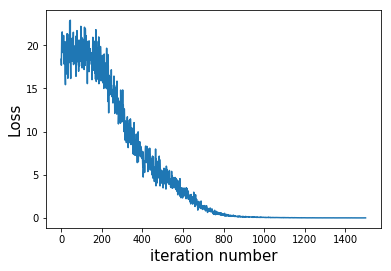

In [6]:
# plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

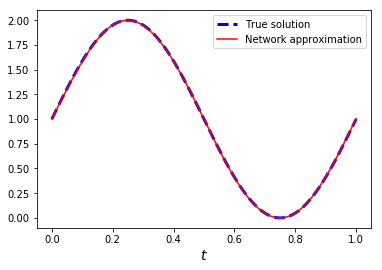

In [7]:
# plot real solution and network approximation
sol = lambda t: np.sin(2 * np.pi * t) + 1
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.solve(pts)
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b--', linewidth=3, label='True solution')
plt.plot(pts, approxs, 'r', label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

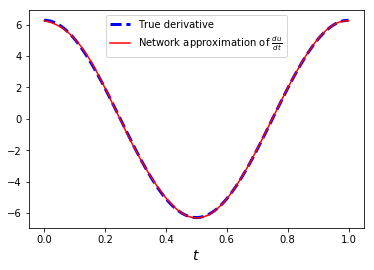

In [8]:
# plot approximation of solution-derivative
der = lambda t: 2 * np.pi * np.cos(2 * np.pi * t)
true_der = [der(t[0]) for t in pts]
ders = dg.solve(pts, fetches='dt')
plt.plot(pts, true_der, 'b--', linewidth=3, label=r'True derivative')
plt.plot(pts, ders, 'r', label=r'Network approximation of $\frac{d u}{d t}$')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

<a id='ex2'></a>

* poisson equation in $\mathcal{R}^2$ with Dirichlet boundary condition

$$\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 5\sin[\pi(x + y)];\quad (x, y) \in [0, 1]^2,\ f(0, y)=f(x, 0)=f(1, y)=f(x, 1)=1.
$$

In [9]:
# describing pde-problem in pde-dict
pde = {'n_dims': 2,
       'form': lambda u, x, y: D(D(u, x), x) + D(D(u, y), y) - 5 * sin(np.pi * (x + y)),
       'boundary_condition': 1}                       # will be transformed into callable returning 1

# network-architecture and loss-function
body = {'layout': 'fa fa fa f',
        'units': [15, 25, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'track': {'d2x+d2y': lambda u, x, y: D(D(u, x), x) + D(D(u, y), y)}}    # another way of tracking additional expressions

# uniform sampling scheme (using alias)
s = NumpySampler('u', dim=2)

In some cases, it is more convinient to use `DGSolver` wrapper:

In [10]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=100, sampler=s, n_iters=1500, bar='notebook')

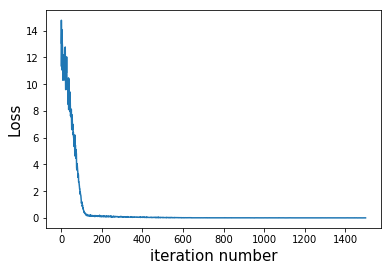

In [11]:
# plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

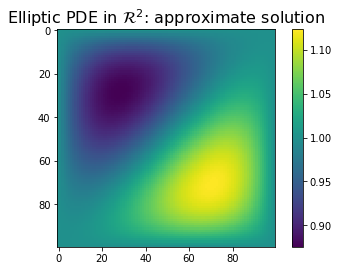

In [12]:
# plot network approximation of a solution
n_el = 100
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))
approxs = dg.solve(grid)

plt.title('Elliptic PDE in $\mathcal{R}^2$: approximate solution', fontdict={'fontsize': 16})
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.show()

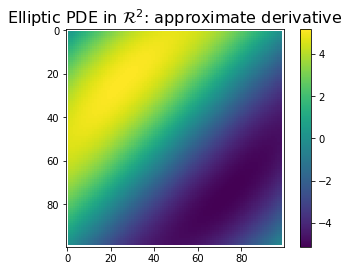

In [13]:
# plot approximation of solution-derivative
ders = dg.solve(grid, fetches='d2x+d2y')
plt.title('Elliptic PDE in $\mathcal{R}^2$: approximate derivative', fontdict={'fontsize': 16})
plt.imshow(ders.reshape(n_el, n_el))
plt.colorbar()
plt.show()

<a id='ex3'></a>

* heat equation in $\mathcal{R}^2 \times \mathcal{R}$

$$\frac{\partial f}{\partial t} - \frac{\partial^2 f}{\partial x^2} - \frac{\partial^2 f}{\partial y^2} = 5xy(1 - x)(1 - y) \cos[\pi(x + y)];\quad (x, y, t) \in [0, 1]^2 \times [0, 1],\ f(x, y, 0) = xy(1 - x)(1 - y).
$$

In [14]:
# describing pde-problem in pde-dict
pde = {'n_dims': 3,
       'form': lambda u, x, y, t: (D(u, t) - D(D(u, x), x) - D(D(u, y), y)
                                   - 5 * x * y * (1 - x) * (1 - y) * cos(np.pi * (x + y))),
       'initial_condition': lambda x, y: x * y * (1 - x) * (1 - y)}

# network-architecture and loss-function
body = {'layout': 'fa fa fa f',
        'units': [15, 25, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss}

# uniform sampling scheme
s = NumpySampler('u', dim=3)

In [15]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=200, sampler=s, n_iters=5000, bar='notebook')

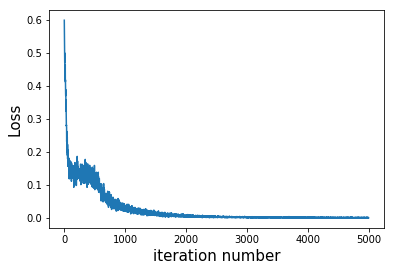

In [16]:
# plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

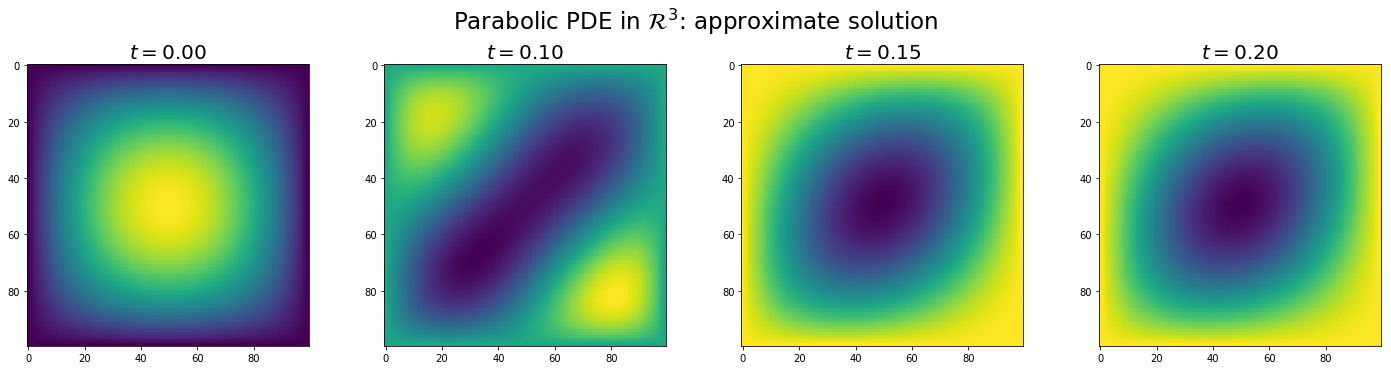

In [17]:
# plot network approximation of a solution
n_sections = 4
timestamps = (0, 0.1, 0.15, 0.2)
n_el = 100
fig, axes = plt.subplots(1, n_sections, figsize=(5 * n_sections, 5))
cart = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))

for i, t_ in enumerate(timestamps):
    grid = np.concatenate([cart, t_ * np.ones(shape=(n_el**2, 1))], axis=1)
    approxs = dg.solve(grid)
    axes[i].imshow(approxs.reshape(n_el, n_el))
    axes[i].set_title('$t=%.2f$' % t_, size=20)
fig.tight_layout()
fig.suptitle('Parabolic PDE in $\mathcal{R}^3$: approximate solution', size=23)
fig.subplots_adjust(top=0.82)
fig.show()

<a id='ex4'></a>

* wave equation in $\mathcal{R} \times \mathcal{R}$ (evolution equation of plucked string with fixed ends)

$$ \frac{\partial^2 f}{\partial t^2} - \frac{\partial^2 f}{\partial x^2} = 0 ; \quad (x, t) \in [0, 1] \times [0, 1],\ f(x, 0)=x(1 - x),\ \frac{\partial f}{\partial t}(x, 0)= 0.
$$

It is reasonable to set `time_multiplier` to `polynomial` since we know that solution is oscillating endlessly.

In [18]:
# describing pde-problem in pde-dict
pde = {'n_dims': 2,
       'form': lambda u, x, t: D(D(u, t), t) - D(D(u, x), x),
       'initial_condition': [lambda x: x * (1 - x), 0],
       'time_multiplier': 'polynomial'}

# network-architecture and loss-function
body = {'layout': 'faR fa fa+ f',
        'units': [10, 25, 10, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'track': {'dt': lambda u, x, t: D(u, t)}}

# uniform spatial sampling and exponential time-sampling
s = NumpySampler('u') & NumpySampler('e', scale=1).truncate(3.0)

In [19]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=200, sampler=s, n_iters=10000, bar='notebook')

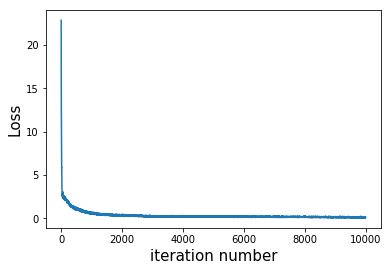

In [20]:
# plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

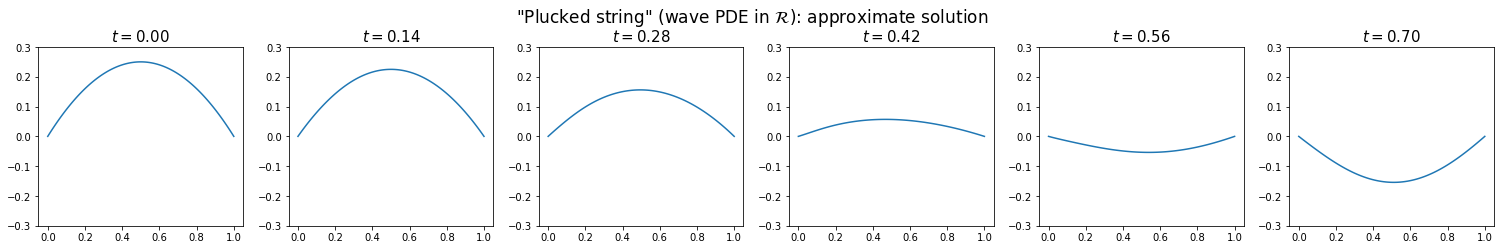

In [21]:
# plot network approximation of a solution
n_sections = 6
timestamps = (0., 0.14, 0.28, 0.42, 0.56, 0.7)
n_el = 100
fig, axes = plt.subplots(1, n_sections, figsize=(3.5 * n_sections, 3.5))
cart = np.linspace(0, 1, n_el).reshape((n_el, 1))

for i, t_ in enumerate(timestamps):
    grid = np.concatenate([cart, t_ * np.ones(shape=(n_el, 1))], axis=1)
    approxs = dg.solve(grid)
    axes[i].plot(cart, approxs.reshape(n_el, ))
    axes[i].set_title('$t=%.2f$' % t_, size=15)
    axes[i].set_ylim(-0.3, 0.3)
    
fig.tight_layout()
fig.suptitle('"Plucked string" (wave PDE in $\mathcal{R}$): approximate solution', size=17)
fig.subplots_adjust(top=0.82)
fig.show()

<a id='ex5'></a>

* equation with non-constant coefficients in the left-hand side

$$
\frac{1}{f(t)} \frac{\partial u}{\partial t} = 1, \quad
\\
f(t) = 15 + \sin(5t) + 5(t+2)\sin(5t)
\\
u(0) = 30.
$$

In [22]:
# describing pde-problem in pde-dict
f_t = lambda t: ((15 + sin(5 * t))  +  5 * (t + 2) * cos(5 * t))
pde = {'form': lambda u, t: D(u, t) / f_t(t) - 1,
       'n_dims': 1,
       'initial_condition': 15 * 2}

# network-architecture and loss-function
b = 3
body = {'layout': 'fa' * b +  'f',
        'units': [25] * b + [1],
        'activation': [tf.nn.tanh] * b}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'track': {'dt': lambda u, t: D(u, t)}}

# uniform sampling scheme
s = NumpySampler('u')

In [23]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=100, sampler=s, n_iters=10000, bar='notebook')

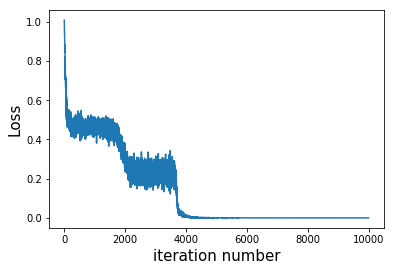

In [24]:
# plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

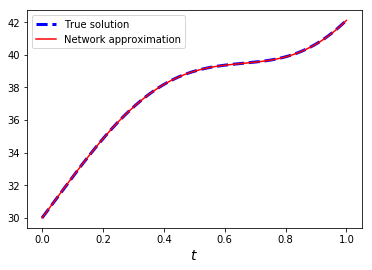

In [25]:
# plot real solution and network approximation
sol = lambda t: (15 + np.sin(5 * t)) * (2 + t)
pts = np.linspace(0, 1, 200).reshape(-1, 1)
approxs = dg.solve(pts)
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b--', linewidth=3, label='True solution')
plt.plot(pts, approxs, 'r', label='Network approximation')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

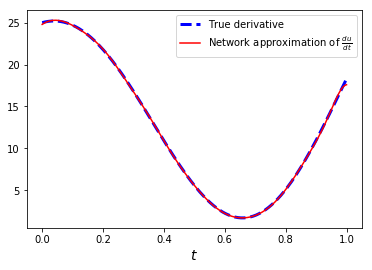

In [26]:
# plot approximation of solution-derivative
der = lambda t: ((15 + np.sin(5 * t))  +  5 * (t + 2) * np.cos(5 * t))
true_der = [der(t[0]) for t in pts]
ders = dg.solve(pts, fetches='dt')
plt.plot(pts, true_der, 'b--', linewidth=3, label=r'True derivative')
plt.plot(pts, ders, 'r', label=r'Network approximation of $\frac{d u}{d t}$')
plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.show()

# EXTRA <span style="font-family:Papyrus; font-size:0.25em;"> will be moved to other tutorials later </span>

<a id='ex6'></a>

With `DeepGalerkin`, it is also possible to solve system of equations. The basic semantics are the same, but `form`, `initial_condition`, `boundary_condition` are now lists of separate equations or conditions for each function respectively. You also have to provide additional information on equation by passing `n_funs` and `n_eqns` to PDE-configuration to communicate number of functions and number of equations of the problem.

Under the hood, each unknown function is approximated with a neural network: they have common `body` part and separate `head`'s. You can easily control, how much of the computational flow is shared between each approximator by adjusting `body`/`head` configs. 

* system of two equations:

\begin{cases}
u_1(t) + \dfrac{\partial u_2(t)}{ \partial t} = 0 \\
u_2(t) + \dfrac{\partial u_1(t)}{ \partial t} = 2 \cos(t)
\end{cases}

$$
u_1(0)=0, \quad u_2(0)=1.
$$

It is easy to see that $u_1(t) = \sin(t)$ and $u_2(t) = \cos(t)$ satisfy both system of equations and initial conditions.

In [27]:
pde = {'n_dims': 1, 'n_funs': 2, 'n_eqns': 2,
       'form': [lambda u0, u1, t: u0 + D(u1, t),
                lambda u0, u1, t: u1 + D(u0, t) - 2 * cos(t)],
       'initial_condition': [[0.0],
                             [1.0]],
       'time_multiplier': 'polynomial'}

body = {'layout': 'fa',
        'units': 40,
        'activation': tf.nn.tanh}

head = {'layout': 'fa fa' + 'f',
        'units': [10, 10, 1],
        'activation': [tf.nn.tanh]*2}

loss = 'mse'

# Put it all together in model-config
config = {'pde': pde,
          'body': body,
          'head': head,
          'loss': loss,
         }  

# Uniform sampling scheme
s = NumpySampler('u', dim=1)

In [28]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=50, sampler=s, n_iters=200, bar='notebook')

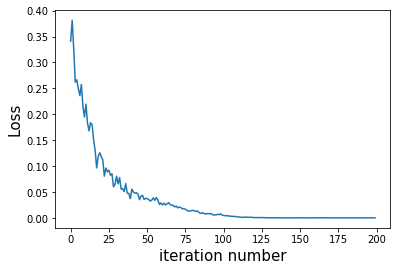

In [29]:
# Plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss', fontdict={'fontsize': 15})
plt.show()

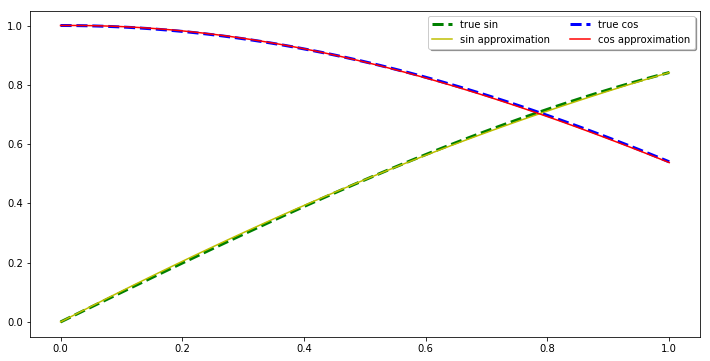

In [30]:
# Plot true solutions and their approximations
n_el = 100
fig, ax = plt.subplots(figsize=(12, 6))
pts = np.linspace(0, 1, n_el).reshape((n_el, 1))

true_sin = [np.sin(t_) for t_ in pts]
approxs_sin = dg.solve(pts)[:, 0]
true_cos = [np.cos(t_) for t_ in pts]
approxs_cos = dg.solve(pts)[:, 1]

plt.plot(pts, true_sin, 'g--', linewidth=3, label='true sin')
plt.plot(pts, approxs_sin.reshape(n_el, ), 'y', label='sin approximation')
plt.plot(pts, true_cos, 'b--',  linewidth=3, label='true cos')
plt.plot(pts, approxs_cos.reshape(n_el, ), 'r', label='cos approximation')

plt.legend(loc='upper right', shadow=True, ncol=2)
fig.show()

# Inverse problem for PDE

In [31]:
# describing pde-problem in pde-dict
K = 5
block = {'layout': 'fa Rfa fa. fa f',
         'units': [15]*4 + [1],
         'activation': tf.nn.tanh}

pde = {'n_dims': 1,
       'form': lambda u, t: (D(u, t)*(1 + V(0.0, 'der', **block))
                             - u*(1 + V(0.0, 'fun'))
                             - K*cos(K*t)*exp(t) + C(u, t, 'rhs', **block)
                            ),
#        'form': lambda u, t: D(u, t)*(1) - u - K*cos(K*t)*exp(t),
       'time_multiplier': 'polynomial',
       'initial_condition': 0.0,
#        'initial_condition': lambda: V(0.0, 'initcond'),
       'bind_bc_ic': True}   


body = {'layout': 'fa fa f',
        'units': [10, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh]}

# put it together in model-config
config = {'pde': pde,
          'body': body,
          'loss': 'mse',
          'track': {'expr': lambda u, t: u - (sin(K*t)*exp(t)+2)},
          'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05},
          'train_steps': {
              'adds': {'scope': 'addendums'},
              'cond_1': {'scope': '-addendums',
                         'loss':{'name': 'mse', 'predictions':'expr'}},
              'rest': {'scope': '-addendums'}
           },
         }

# uniform sampling scheme
s = NumpySampler('uniform')
s_cond_1 = NumpySampler('uniform', low=0.5, high=0.8)# ConstantSampler(0.5)

In [32]:
# train the network on batches of 100 points
dg = DeepSolver(config)
# dg.fit(batch_size=100, sampler=s, n_iters=1500, bar='notebook')

iters = [10, 5, 5] * 5

for _ in tqdm_notebook(range(200)):
    _ = dg.fit(batch_size=100, sampler=s, n_iters=iters[0], fetches='loss_rest', train_mode='rest')
    
    _ = dg.fit(batch_size=100, sampler=s_cond_1, n_iters=iters[1], fetches='loss_cond_1', train_mode='cond_1')

    _ = dg.fit(batch_size=100, sampler=s, n_iters=iters[2], fetches='loss_adds', train_mode='adds')

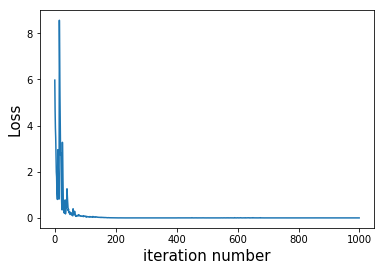

In [33]:
# plot loss
plt.plot(dg.loss_cond_1[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss',fontdict={'fontsize': 15})
plt.show()

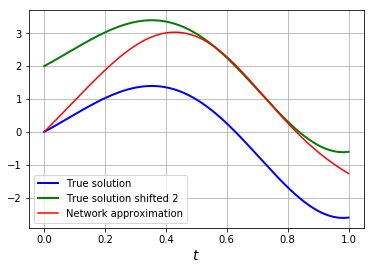

In [34]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

sol = lambda t: np.sin(K*t)*np.exp(t) + 0
true = [sol(t[0]) for t in pts]
plt.plot(pts, true, 'b', linewidth=2, label='True solution')

shifted = [sol(t[0])+2 for t in pts]
plt.plot(pts, shifted, 'g', linewidth=2, label='True solution shifted 2')

approxs = dg.solve(pts)
plt.plot(pts, approxs, 'r', label='Network approximation')

plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()

In [35]:
dg.solve(fetches='fun')

0.11270577

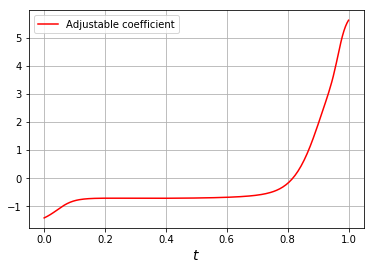

In [36]:
# plot real solution and network approximation
pts = np.linspace(0, 1, 200).reshape(-1, 1)

approxs = dg.solve(pts, fetches='rhs')
plt.plot(pts, approxs, 'r', label='Adjustable coefficient')

plt.xlabel(r'$t$', fontdict={'fontsize': 14})
plt.legend()
plt.grid(True)
plt.show()

In [37]:
with dg.model.graph.as_default():
    collection = dg.model._make_scope({'scope': 'addendums'}, '/device:CPU:0')
collection

[<tf.Variable 'TFDeep/device_CPU_0/addendums/der:0' shape=() dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/fun:0' shape=() dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-0/dense/kernel:0' shape=(2, 15) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-0/dense/bias:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-3/dense/kernel:0' shape=(15, 15) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-3/dense/bias:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-5/dense/kernel:0' shape=(15, 15) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-5/dense/bias:0' shape=(15,) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-8/dense/kernel:0' shape=(30, 15) dtype=float32_ref>,
 <tf.Variable 'TFDeep/device_CPU_0/addendums/rhs/layer-8/dense/bias:0' shape=(15,) dtype=float32_r

# Perturbations example

In [38]:
pde = {'n_dims': 1,
       'form': lambda u, t, e: D(u, t) - P(e) * np.pi * cos(P(e) * np.pi * t),
       'initial_condition': 1 # will be transformed into callable returning 1
      }

# network-architecture and loss-function
body = {'layout': 'fa fa f',
        'units': [10, 15, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh]}
loss = 'mse'

# put it together in model-config
config = {'body': body,
          'pde': pde,
          'loss': loss,
          'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05},
          'track': {'dt': lambda u, t, e: D(u, t)}}

# uniform sampling scheme
s = NumpySampler('uniform') & NumpySampler('uniform', low=1, high=5)

In [39]:
# train the network on batches of 100 points
dg = DeepSolver(config)
dg.fit(batch_size=1000, sampler=s, n_iters=5000, bar='notebook')

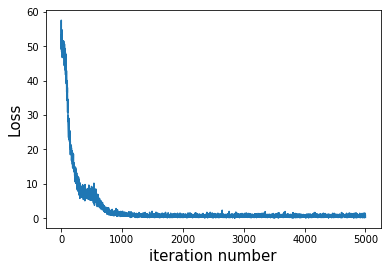

In [40]:
# Plot loss
plt.plot(dg.loss[:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss', fontdict={'fontsize': 15})
plt.show()

In [41]:
from ipywidgets import interact

def plt_solution(e):
    # plot real solution and network approximation
    sol = lambda t: np.sin(e * np.pi * t) + 1
    pts = np.concatenate([np.linspace(0, 1, 200).reshape(-1, 1), e * np.ones((200, 1))], axis=1)
    approxs = dg.solve(pts)
    true = sol(pts[:, 0])
    plt.plot(pts[:, 0], true, 'b--', linewidth=3, label='True solution')
    plt.plot(pts[:, 0], approxs, 'r', label='Network approximation')
    plt.xlabel(r'$t$', fontdict={'fontsize': 14})
    plt.legend()
    plt.show()

In [42]:
_ = interact(plt_solution, e=(1, 5, 0.01))

interactive(children=(FloatSlider(value=3.0, description='e', max=5.0, min=1.0, step=0.01), Output()), _dom_cl…